In [17]:
!pip3 install seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 294 kB 8.7 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
plt.rcParams.update({'font.size': 18})

In [10]:
### Parameters
Nneurons = 10000
dt=0.1
simulation_time = 2000
tf = np.arange(0,simulation_time,dt)

In [ ]:
class HHca:
    nid=0 #default neuron id
    sendspk=0

    C = 1
    Gl=0.05
    Vl = -70
    Gna = 35
    Gnap = 0.3 #varies between 0 and 0.41 mS/cm2
    thetam = -30
    deltam = 9.5
    Vna = 55
    Gkdr = 6
    thetah = -45
    deltah = -7
    thetaht= -40.5
    deltaht= -6
    Vk = -90
    thetap = -47 #-47#-41 #varies between -47mV and -41mV
    deltap = 3
    thetan = -35
    deltan = 10
    thetant =-27
    deltant=-15
    Ga = 1.4
    thetaa = -50
    deltaa = 20
    taub = 15
    thetab = -80
    deltab = -6
    Gm = 1
    tauz = 75
    thetaz = -39
    deltaz = 5

    Gca = 0.#0*0.2 #varies between 0 and 0.2 mS/cm2
    Gc = 10
    Gsahp = 5
    Vca = 120
    thetar=-20
    deltar=10
    taur=1
    thetac=-30
    deltac=7
    tauc=2
    ac=6
    tauq=450
    aq=2

    nu=0.13
    tauca=13

    Iapp = 0

    D = 0.0

    Ein=-80.
    Eex=0.
    Gie=0.08
    Goe=0.08#0.15
    tauR_ampa = 0.1
    tauD_ampa = 3.0
    tauR_gaba = 0.2
    tauD_gaba = 20.

    vth=0

    countdelay=0

    spktimes = []


    def __init__(self,nid=1,D=0.1,Gnap=0.3,Gkbar=6,Ga = 1.4,Gm = 1,Gca = 0.,Gc = 10,Gsahp = 5,Ca_acum=0.0001, No = 1.0, Ni=1.0):
        self.Gie = self.Gie/Ni
        self.Goe = self.Goe/No
        self.minf= lambda V:  1.0/(1+np.exp(-(V-self.thetam)/self.deltam))
        self.hinf= lambda V:  1.0/(1+np.exp(-(V-self.thetah)/self.deltah))
        self.tauh= lambda V:  0.1 + 0.75*(1.0/(1+np.exp(-(V-self.thetaht)/self.deltaht)))
        self.ninf= lambda V:  1.0/(1+np.exp(-(V-self.thetan)/self.deltan))
        self.taun= lambda V:  0.1 + 0.5*(1.0/(1+np.exp(-(V-self.thetant)/self.deltant)))
        self.pinf= lambda V:  1.0/(1+np.exp(-(V-self.thetap)/self.deltap))
        self.ainf= lambda V:  1.0/(1+np.exp(-(V-self.thetaa)/self.deltaa))
        self.binf= lambda V:  1.0/(1+np.exp(-(V-self.thetab)/self.deltab))
        self.zinf= lambda V:  1.0/(1+np.exp(-(V-self.thetaz)/self.deltaz))

        self.rinf= lambda V:  1.0/(1+np.exp(-(V-self.thetar)/self.deltar))
        self.cinf= lambda V:  1.0/(1+np.exp(-(V-self.thetac)/self.deltac))
        self.dinf= lambda Ca_acum:  1.0/(1+self.ac/Ca_acum)
        self.qinf= lambda Ca_acum:  1.0/(1+(self.aq**4)/(Ca_acum**4))

        self.Nv = lambda V: ( 1+np.tanh(V/4.0) )#/2.

        self.nid = nid
        self.D = D
        self.v = -72.#-89.09
        self.h = 0
        self.n = 0
        self.b = 0
        self.z = 0
        self.s = 0
        self.sie=0
        self.soe=0
        self.r=0
        self.c=0
        self.Gm = Gm
        self.Ca_acum=Ca_acum #0.1#1.2#2.0
        self.Gnap=Gnap
        self.Gkdr=Gkbar
        self.Ga = Ga
        self.Gca = Gca
        self.Gc = Gc
        self.Gsahp = Gsahp
        self.q=0
        self.spktimes = []

    def _UpdateKs(self,v,h,n,b,z,r,c,Ca_acum,q,s,stim):
        Isyn = self.Gie*self.sie*(v-self.Ein) + self.Goe*self.soe*(v-self.Ein)

        Il = self.Gl * (v - self.Vl)
        Ina  = self.Gna * (self.minf(v)**3) * h *(v-self.Vna)
        Inap = self.Gnap * self.pinf(v) * (v-self.Vna)
        Ikdr = self.Gkdr * (n**4) * (v-self.Vk)
        IA   = self.Ga * (self.ainf(v)**3) * b * (v-self.Vk)
        IM   = self.Gm * z * (v-self.Vk)

        Ica  = self.Gca * (r**2) * (v-self.Vca)
        Ic   = self.Gc * self.dinf(Ca_acum) * c * (v-self.Vk)
        Isahp= self.Gsahp * q * (v-self.Vk)

        Itotal =  self.Iapp - Il - Ina - Inap - Ikdr - IA - IM - Ica - Ic - Isahp + stim - Isyn

        kv = Itotal / (self.C)
        kh = (self.hinf(v)-h)/self.tauh(v)
        kn = (self.ninf(v)-n)/self.taun(v)
        kb = (self.binf(v)-b)/self.taub
        kz = (self.zinf(v)-z)/self.tauz

        kr = (self.rinf(v)-r)/self.taur
        kc = (self.cinf(v)-c)/self.tauc
        kCa_acum = -self.nu*Ica - Ca_acum/self.tauca
        kq = (self.qinf(Ca_acum)-q)/self.tauq

        ks = self.Nv(v)*(1-s)/self.tauR_ampa - s/self.tauD_ampa

        return kv, kh, kn, kb, kz, kr, kc, kCa_acum, kq, ks

    def _Updatev(self,stim,sie,soe,dt,time):
        self.sie = sie
        self.soe = soe
        if(self.countdelay>0):
            self.countdelay-=dt
        if(self.countdelay<0):
            self.countdelay=0
            self.s += 1

        k1v, k1h, k1n, k1b, k1z, k1r, k1c, k1Ca_acum, k1q, k1s = self._UpdateKs(self.v,self.h,self.n,self.b,self.z,self.r,self.c,self.Ca_acum,self.q,self.s,stim)
        a_v= self.v + k1v*dt/2
        a_h= self.h + k1h*dt/2
        a_n= self.n + k1n*dt/2
        a_b= self.b + k1b*dt/2
        a_z= self.z + k1z*dt/2
        a_r= self.r + k1r*dt/2
        a_c= self.c + k1c*dt/2
        a_Ca_acum= self.Ca_acum + k1Ca_acum*dt/2
        a_q= self.q + k1q*dt/2
        a_s= self.s + k1s*dt/2

        k2v, k2h, k2n, k2b, k2z, k2r, k2c, k2Ca_acum, k2q, k2s = self._UpdateKs(a_v,a_h,a_n,a_b,a_z,a_r,a_c,a_Ca_acum,a_q,a_s,stim)
        a_v= self.v + k2v*dt/2
        a_h= self.h + k2h*dt/2
        a_n= self.n + k2n*dt/2
        a_b= self.b + k2b*dt/2
        a_z= self.z + k2z*dt/2
        a_r= self.r + k2r*dt/2
        a_c= self.c + k2c*dt/2
        a_Ca_acum= self.Ca_acum + k2Ca_acum*dt/2
        a_q= self.q + k2q*dt/2
        a_s= self.s + k2s*dt/2

        k3v, k3h, k3n, k3b, k3z, k3r, k3c, k3Ca_acum, k3q, k3s = self._UpdateKs(a_v,a_h,a_n,a_b,a_z,a_r,a_c,a_Ca_acum,a_q,a_s,stim)
        a_v= self.v + k3v*dt
        a_h= self.h + k3h*dt
        a_n= self.n + k3n*dt
        a_b= self.b + k3b*dt
        a_z= self.z + k3z*dt
        a_r= self.r + k3r*dt
        a_c= self.c + k3c*dt
        a_Ca_acum= self.Ca_acum + k3Ca_acum*dt
        a_q= self.q + k3q*dt
        a_s= self.s + k3s*dt

        k4v, k4h, k4n, k4b, k4z, k4r, k4c, k4Ca_acum, k4q, k4s = self._UpdateKs(a_v,a_h,a_n,a_b,a_z,a_r,a_c,a_Ca_acum,a_q,a_s,stim)
        self.v += dt*(k1v+2*k2v+2*k3v+k4v)/6 + np.random.randn()*np.sqrt(2*self.D*dt)
        self.h += dt*(k1h+2*k2h+2*k3h+k4h)/6
        self.n += dt*(k1n+2*k2n+2*k3n+k4n)/6
        self.b += dt*(k1b+2*k2b+2*k3b+k4b)/6
        self.z += dt*(k1z+2*k2z+2*k3z+k4z)/6
        self.r += dt*(k1r+2*k2r+2*k3r+k4r)/6
        self.c += dt*(k1c+2*k2c+2*k3c+k4c)/6
        self.Ca_acum += dt*(k1Ca_acum+2*k2Ca_acum+2*k3Ca_acum+k4Ca_acum)/6
        self.q += dt*(k1q+2*k2q+2*k3q+k4q)/6
        self.s += dt*(k1s+2*k2s+2*k3s+k4s)/6

        self.sendspk=0
        if(self.v>self.vth):
            self.spktimes.append(time)
            self.sendspk=1

    def add_pre_spike(self,delay):
        self.countdelay = delay
        self.sendspk=0

    def delay_count(self,delay):
        self.countdelay = delay

    def add_external(self):
        self.sext += 1

    def eval(self,stim,sie,soe,dt,time):
        self._Updatev(stim,sie,soe,dt,time)

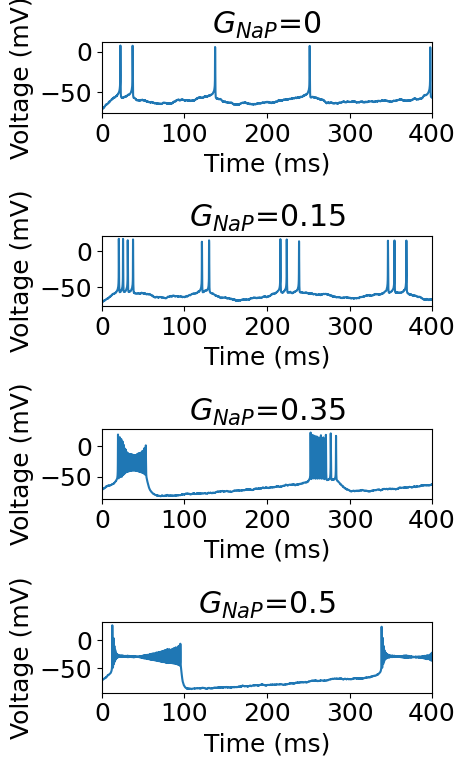

In [12]:
#######
###just input
Izap = lambda i, Fzap, A: A*np.sin(2*np.pi*Fzap*10**-3*i*dt + 3*np.pi/2)

trials = 1
gn = [0, 0.15, 0.35,0.5]
freq_range = [0]
plt.figure(figsize=(5,8))  
count=0
for g in gn:
    count = count + 1
    rate = np.zeros(len(freq_range))
    for j in range(trials):
        countrate = 0
        for ff in freq_range:
            neuron = HHca(D=0.1,Gnap=g)
            v = np.zeros(len(tf))
            spktrain = np.zeros(round(2000/dt))

            I = np.zeros_like(tf)
            freq = ff
            curr_level=1

            for i in range(len(tf)-1):
                neuron.eval(curr_level,0,0,dt,i*dt)
                v[i] = neuron.v

            peaks, _ = find_peaks(v, height=0)
            rate[countrate] = rate[countrate] + (len(peaks)/2)/trials
            countrate = countrate + 1
      
    plt.subplot(4,1,count)
    plt.rcParams.update({'font.size': 18})
    plt.plot(tf,v)
    plt.xlim([0,400])
    # plt.xlim([freq_range[0],freq_range[-1]])
    plt.title(r'$G_{NaP}$=' + str(g))
    plt.ylabel('Voltage (mV)')
    plt.xlabel('Time (ms)')
    plt.tight_layout()

plt.savefig('gnapv.png')
plt.savefig('gnapv.pdf')

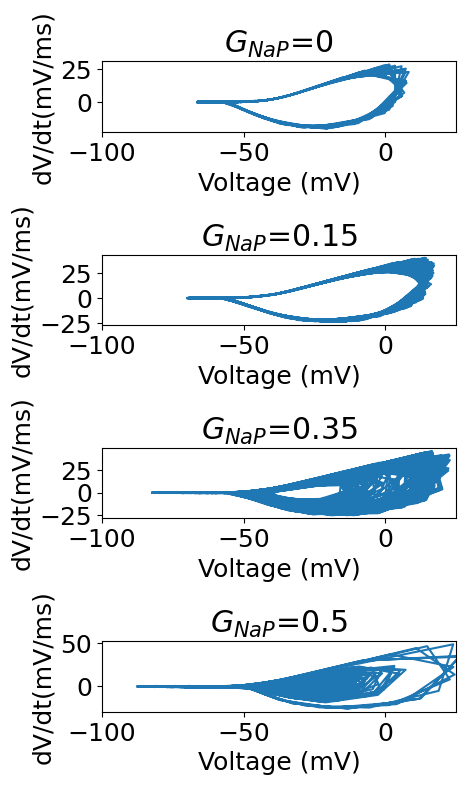

In [23]:
#######
###just input
Izap = lambda i, Fzap, A: A*np.sin(2*np.pi*Fzap*10**-3*i*dt + 3*np.pi/2)

trials = 1
gn = [0, 0.15, 0.35,0.5]
freq_range = [0]
plt.figure(figsize=(5,8))  
count=0
for g in gn:
    count = count + 1
    rate = np.zeros(len(freq_range))
    for j in range(trials):
        countrate = 0
        for ff in freq_range:
            neuron = HHca(D=0.1,Gnap=g)
            v = np.zeros(len(tf))
            spktrain = np.zeros(round(2000/dt))

            I = np.zeros_like(tf)
            freq = ff
            curr_level=1

            for i in range(len(tf)-1):
                neuron.eval(curr_level,0,0,dt,i*dt)
                v[i] = neuron.v

            peaks, _ = find_peaks(v, height=0)
            rate[countrate] = rate[countrate] + (len(peaks)/2)/trials
            countrate = countrate + 1
      
    plt.subplot(4,1,count)
    plt.rcParams.update({'font.size': 18})
    # plt.plot(tf,v)
    plt.plot(v[100:-100],np.diff(v)[99:-100])
    plt.xlim([-100,25])
    # plt.xlim([freq_range[0],freq_range[-1]])
    plt.title(r'$G_{NaP}$=' + str(g))
    plt.ylabel('dV/dt(mV/ms)')
    plt.xlabel('Voltage (mV)')
    plt.tight_layout()

plt.savefig('gnapdvdt.png')
plt.savefig('gnapdvdt.pdf')

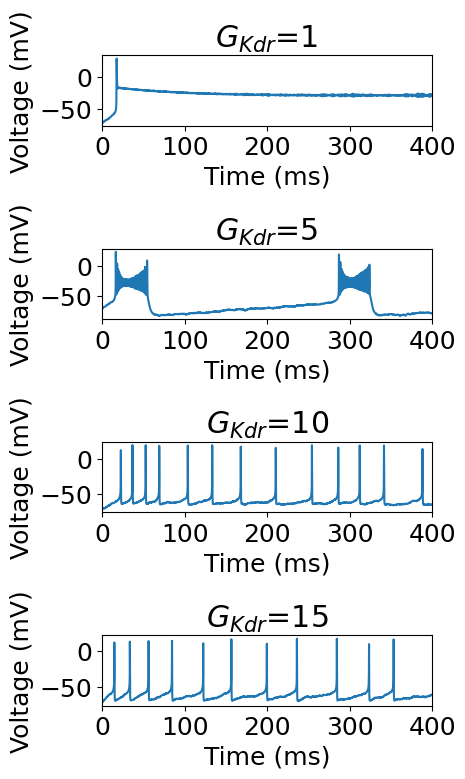

In [25]:
#
#######
###just input
Izap = lambda i, Fzap, A: A*np.sin(2*np.pi*Fzap*10**-3*i*dt + 3*np.pi/2)

trials = 1
gn = [1, 5, 10, 15]
freq_range = [0]
plt.figure(figsize=(5,8))  
count=0
for g in gn:
    count = count + 1
    rate = np.zeros(len(freq_range))
    for j in range(trials):
        countrate = 0
        for ff in freq_range:
            neuron = HHca(D=0.1,Gkbar=g)
            v = np.zeros(len(tf))
            spktrain = np.zeros(round(2000/dt))

            I = np.zeros_like(tf)
            freq = ff
            curr_level=1

            for i in range(len(tf)-1):
                neuron.eval(curr_level,0,0,dt,i*dt)
                v[i] = neuron.v

            peaks, _ = find_peaks(v, height=0)
            rate[countrate] = rate[countrate] + (len(peaks)/2)/trials
            countrate = countrate + 1
      
    plt.subplot(4,1,count)
    plt.rcParams.update({'font.size': 18})
    plt.plot(tf,v)
    plt.xlim([0,400])
    # plt.xlim([freq_range[0],freq_range[-1]])
    plt.title(r'$G_{Kdr}$=' + str(g))
    plt.ylabel('Voltage (mV)')
    plt.xlabel('Time (ms)')
    plt.tight_layout()

plt.savefig('gkdr.png')
plt.savefig('gkdr.pdf')

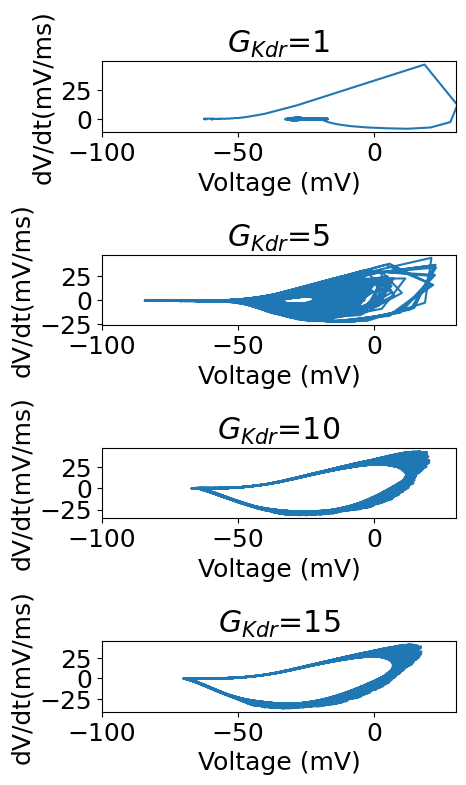

In [27]:
#
#######
###just input
Izap = lambda i, Fzap, A: A*np.sin(2*np.pi*Fzap*10**-3*i*dt + 3*np.pi/2)

trials = 1
gn = [1, 5, 10, 15]
freq_range = [0]
plt.figure(figsize=(5,8))  
count=0
for g in gn:
    count = count + 1
    rate = np.zeros(len(freq_range))
    for j in range(trials):
        countrate = 0
        for ff in freq_range:
            neuron = HHca(D=0.1,Gkbar=g)
            v = np.zeros(len(tf))
            spktrain = np.zeros(round(2000/dt))

            I = np.zeros_like(tf)
            freq = ff
            curr_level=1

            for i in range(len(tf)-1):
                neuron.eval(curr_level,0,0,dt,i*dt)
                v[i] = neuron.v

            peaks, _ = find_peaks(v, height=0)
            rate[countrate] = rate[countrate] + (len(peaks)/2)/trials
            countrate = countrate + 1
      
    plt.subplot(4,1,count)
    plt.rcParams.update({'font.size': 18})
    # plt.plot(tf,v)
    plt.plot(v[100:-100],np.diff(v)[99:-100])
    plt.xlim([-100,30])
    # plt.xlim([freq_range[0],freq_range[-1]])
    plt.title(r'$G_{Kdr}$=' + str(g))
    plt.ylabel('dV/dt(mV/ms)')
    plt.xlabel('Voltage (mV)')
    plt.tight_layout()

plt.savefig('gkdrdvdt.png')
plt.savefig('gkdrdvdt.pdf')

In [14]:
len(np.arange(0,15,0.3))


50

In [21]:
#ga
trials = 1
gn = [0, 0.15, 0.35]

range_input =np.arange(0,5,0.1) #[1,2,3] # ##np.arange(1.0,1.5,0.05) #0.025)
range_gn = np.arange(0,2.8,0.05) #[0, 0.15, 0.35] # ##np.arange(0,1,0.1) #[0, 0.15, 0.35] # #0.01)
dataf = np.zeros((len(range_input),len(range_gn)))
datacv = np.zeros((len(range_input),len(range_gn)))

counti=0
for m in range_input:
  countj=0
  for n in range_gn:
        neuron = HHca(D=0.1,Ga=n)
        v = np.zeros(len(tf))

        I = np.zeros_like(tf)
        freq = ff
        curr_level=m

        for i in range(len(tf)-1):
            neuron.eval(curr_level,0,0,dt,i*dt)
            v[i] = neuron.v

        peaks, _ = find_peaks(v, height=0)

        dataf[counti,countj]=(len(peaks)/2)
        isi = np.diff(peaks)*dt
        cv = (np.std(isi)/np.mean(isi))
        datacv[counti,countj] = cv

        countj = countj + 1
  counti = counti+1

/Users/cceballos/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/cceballos/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/cceballos/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/cceballos/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cceballos/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

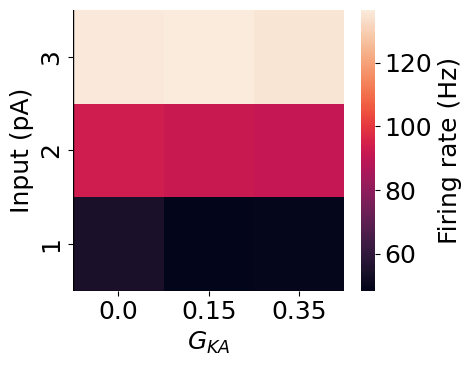

In [19]:
import seaborn as sns
import pandas as pd
# Create a heatmap
df_f = pd.DataFrame(dataf, index = np.round(range_input,3),
                  columns = np.round(range_gn,2))
plt.figure(figsize=(5,4))  
ax = sns.heatmap(df_f,cbar_kws={'label': 'Firing rate (Hz)'})#, vmin=2, vmax=43)
plt.xlabel(r'$G_{KA}$')
plt.ylabel('Input (pA)')
plt.tight_layout()
ax.invert_yaxis()
ax.axhline(y=0, color='k',linewidth=1)
ax.axvline(x=0, color='k',linewidth=1)
# Show the heatmap

plt.savefig('FR_ga.png')
plt.savefig('FR_ga.pdf')
plt.show()

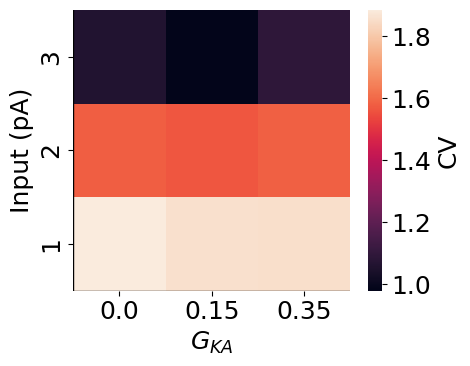

In [20]:
import seaborn as sns
import pandas as pd
# Create a heatmap
df_cv = pd.DataFrame(datacv, index = np.round(range_input,3),
                  columns = np.round(range_gn,2))
plt.figure(figsize=(5,4))  
ax = sns.heatmap(df_cv,cbar_kws={'label': 'CV'})#, vmin=2, vmax=43)
plt.xlabel(r'$G_{KA}$')
plt.ylabel('Input (pA)')
ax.invert_yaxis()
ax.axhline(y=0, color='k',linewidth=1)
ax.axvline(x=0, color='k',linewidth=1)
# Show the heatmap
plt.tight_layout()
plt.savefig('CV_ga.png')
plt.savefig('CV_ga.pdf')
plt.show()

In [ ]:
#gm
trials = 1
gn = [0, 0.15, 0.35]

range_input =np.arange(0,5,0.1) #[1,2,3] # ##np.arange(1.0,1.5,0.05) #0.025)
range_gn = np.arange(0,2.8,0.05) #[0, 0.15, 0.35] # ##np.arange(0,1,0.1) #[0, 0.15, 0.35] # #0.01)
dataf = np.zeros((len(range_input),len(range_gn)))
datacv = np.zeros((len(range_input),len(range_gn)))

counti=0
for m in range_input:
  countj=0
  for n in range_gn:
        neuron = HHca(D=0.1,Gm=n)
        v = np.zeros(len(tf))

        I = np.zeros_like(tf)
        freq = ff
        curr_level=m

        for i in range(len(tf)-1):
            neuron.eval(curr_level,0,0,dt,i*dt)
            v[i] = neuron.v

        peaks, _ = find_peaks(v, height=0)

        dataf[counti,countj]=(len(peaks)/2)
        isi = np.diff(peaks)*dt
        cv = (np.std(isi)/np.mean(isi))
        datacv[counti,countj] = cv

        countj = countj + 1
  counti = counti+1

In [ ]:
import seaborn as sns
import pandas as pd
# Create a heatmap
df_f = pd.DataFrame(dataf, index = np.round(range_input,3),
                  columns = np.round(range_gn,2))
plt.figure(figsize=(5,4))  
ax = sns.heatmap(df_f,cbar_kws={'label': 'Firing rate (Hz)'})#, vmin=2, vmax=43)
plt.xlabel(r'$G_{KM}$')
plt.ylabel('Input (pA)')
plt.tight_layout()
ax.invert_yaxis()
ax.axhline(y=0, color='k',linewidth=1)
ax.axvline(x=0, color='k',linewidth=1)
# Show the heatmap

plt.savefig('FR_gm.png')
plt.savefig('FR_gm.pdf')
plt.show()

In [ ]:
import seaborn as sns
import pandas as pd
# Create a heatmap
df_cv = pd.DataFrame(datacv, index = np.round(range_input,3),
                  columns = np.round(range_gn,2))
plt.figure(figsize=(5,4))  
ax = sns.heatmap(df_cv,cbar_kws={'label': 'CV'})#, vmin=2, vmax=43)
plt.xlabel(r'$G_{KM}$')
plt.ylabel('Input (pA)')
ax.invert_yaxis()
ax.axhline(y=0, color='k',linewidth=1)
ax.axvline(x=0, color='k',linewidth=1)
# Show the heatmap
plt.tight_layout()
plt.savefig('CV_gm.png')
plt.savefig('CV_gm.pdf')
plt.show()

In [ ]:
#gsKCa
trials = 1
gn = [0, 0.15, 0.35]

range_input =np.arange(0,5,0.1) #[1,2,3] # ##np.arange(1.0,1.5,0.05) #0.025)
range_gn = np.arange(0,20,0.5) #[0, 0.15, 0.35] # ##np.arange(0,1,0.1) #[0, 0.15, 0.35] # #0.01)
dataf = np.zeros((len(range_input),len(range_gn)))
datacv = np.zeros((len(range_input),len(range_gn)))

counti=0
for m in range_input:
  countj=0
  for n in range_gn:
        neuron = HHca(D=0.1,Gc=n)
        v = np.zeros(len(tf))

        I = np.zeros_like(tf)
        freq = ff
        curr_level=m

        for i in range(len(tf)-1):
            neuron.eval(curr_level,0,0,dt,i*dt)
            v[i] = neuron.v

        peaks, _ = find_peaks(v, height=0)

        dataf[counti,countj]=(len(peaks)/2)
        isi = np.diff(peaks)*dt
        cv = (np.std(isi)/np.mean(isi))
        datacv[counti,countj] = cv

        countj = countj + 1
  counti = counti+1

In [ ]:
import seaborn as sns
import pandas as pd
# Create a heatmap
df_f = pd.DataFrame(dataf, index = np.round(range_input,3),
                  columns = np.round(range_gn,2))
plt.figure(figsize=(5,4))  
ax = sns.heatmap(df_f,cbar_kws={'label': 'Firing rate (Hz)'})#, vmin=2, vmax=43)
plt.xlabel(r'$G_{sKCa}$')
plt.ylabel('Input (pA)')
plt.tight_layout()
ax.invert_yaxis()
ax.axhline(y=0, color='k',linewidth=1)
ax.axvline(x=0, color='k',linewidth=1)
# Show the heatmap

plt.savefig('FR_gsKCa.png')
plt.savefig('FR_gsKCa.pdf')
plt.show()

In [ ]:
import seaborn as sns
import pandas as pd
# Create a heatmap
df_cv = pd.DataFrame(datacv, index = np.round(range_input,3),
                  columns = np.round(range_gn,2))
plt.figure(figsize=(5,4))  
ax = sns.heatmap(df_cv,cbar_kws={'label': 'CV'})#, vmin=2, vmax=43)
plt.xlabel(r'$G_{sKCa}$')
plt.ylabel('Input (pA)')
ax.invert_yaxis()
ax.axhline(y=0, color='k',linewidth=1)
ax.axvline(x=0, color='k',linewidth=1)
# Show the heatmap
plt.tight_layout()
plt.savefig('CV_gsKCa.png')
plt.savefig('CV_gsKCa.pdf')
plt.show()

In [ ]:
#gfKCa
trials = 1
gn = [0, 0.15, 0.35]

range_input =np.arange(0,5,0.1) #[1,2,3] # ##np.arange(1.0,1.5,0.05) #0.025)
range_gn = np.arange(0,10,0.2) #[0, 0.15, 0.35] # ##np.arange(0,1,0.1) #[0, 0.15, 0.35] # #0.01)
dataf = np.zeros((len(range_input),len(range_gn)))
datacv = np.zeros((len(range_input),len(range_gn)))

counti=0
for m in range_input:
  countj=0
  for n in range_gn:
        neuron = HHca(D=0.1,Gsahp=n)
        v = np.zeros(len(tf))

        I = np.zeros_like(tf)
        freq = ff
        curr_level=m

        for i in range(len(tf)-1):
            neuron.eval(curr_level,0,0,dt,i*dt)
            v[i] = neuron.v

        peaks, _ = find_peaks(v, height=0)

        dataf[counti,countj]=(len(peaks)/2)
        isi = np.diff(peaks)*dt
        cv = (np.std(isi)/np.mean(isi))
        datacv[counti,countj] = cv

        countj = countj + 1
  counti = counti+1

In [ ]:
import seaborn as sns
import pandas as pd
# Create a heatmap
df_f = pd.DataFrame(dataf, index = np.round(range_input,3),
                  columns = np.round(range_gn,2))
plt.figure(figsize=(5,4))  
ax = sns.heatmap(df_f,cbar_kws={'label': 'Firing rate (Hz)'})#, vmin=2, vmax=43)
plt.xlabel(r'$G_{sKCa}$')
plt.ylabel('Input (pA)')
plt.tight_layout()
ax.invert_yaxis()
ax.axhline(y=0, color='k',linewidth=1)
ax.axvline(x=0, color='k',linewidth=1)
# Show the heatmap

plt.savefig('FR_gfKCa.png')
plt.savefig('FR_gfKCa.pdf')
plt.show()

In [ ]:
import seaborn as sns
import pandas as pd
# Create a heatmap
df_cv = pd.DataFrame(datacv, index = np.round(range_input,3),
                  columns = np.round(range_gn,2))
plt.figure(figsize=(5,4))  
ax = sns.heatmap(df_cv,cbar_kws={'label': 'CV'})#, vmin=2, vmax=43)
plt.xlabel(r'$G_{sKCa}$')
plt.ylabel('Input (pA)')
ax.invert_yaxis()
ax.axhline(y=0, color='k',linewidth=1)
ax.axvline(x=0, color='k',linewidth=1)
# Show the heatmap
plt.tight_layout()
plt.savefig('CV_gfKCa.png')
plt.savefig('CV_gfKCa.pdf')
plt.show()

In [15]:
#gkdr
trials = 1
gn = [0, 0.15, 0.35]

range_input =np.arange(0,5,0.1) #[1,2,3] #np.arange(1.0,1.5,0.05) #0.025)
range_gn = np.arange(0,15,0.3) #[0, 0.15, 0.35]#np.arange(0,1,0.1) #[0, 0.15, 0.35] # #0.01)
dataf = np.zeros((len(range_input),len(range_gn)))
datacv = np.zeros((len(range_input),len(range_gn)))

counti=0
for m in range_input:
  countj=0
  for n in range_gn:
        neuron = HHca(D=0.1,Gkbar=n)
        v = np.zeros(len(tf))

        I = np.zeros_like(tf)
        freq = ff
        curr_level=m

        for i in range(len(tf)-1):
            neuron.eval(curr_level,0,0,dt,i*dt)
            v[i] = neuron.v

        peaks, _ = find_peaks(v, height=0)

        dataf[counti,countj]=(len(peaks)/2)
        isi = np.diff(peaks)*dt
        cv = (np.std(isi)/np.mean(isi))
        datacv[counti,countj] = cv

        countj = countj + 1
  counti = counti+1

/Users/rodrigo/anaconda3/envs/bri/lib/python3.7/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/Users/rodrigo/anaconda3/envs/bri/lib/python3.7/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/Users/rodrigo/anaconda3/envs/bri/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/rodrigo/anaconda3/envs/bri/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/rodrigo/anaconda3/envs/bri/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


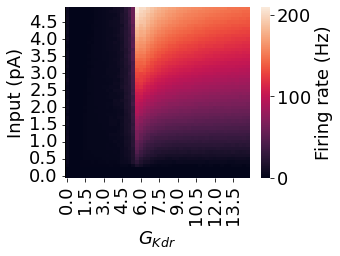

In [16]:
import seaborn as sns
import pandas as pd
# Create a heatmap
df_f = pd.DataFrame(dataf, index = np.round(range_input,3),
                  columns = np.round(range_gn,2))
plt.figure(figsize=(5,4))  
ax = sns.heatmap(df_f,cbar_kws={'label': 'Firing rate (Hz)'})#, vmin=2, vmax=43)
plt.xlabel(r'$G_{Kdr}$')
plt.ylabel('Input (pA)')
plt.tight_layout()
ax.invert_yaxis()
ax.axhline(y=0, color='k',linewidth=1)
ax.axvline(x=0, color='k',linewidth=1)
# Show the heatmap

plt.savefig('FR_gkdr.png')
plt.savefig('FR_gkdr.pdf')
plt.show()

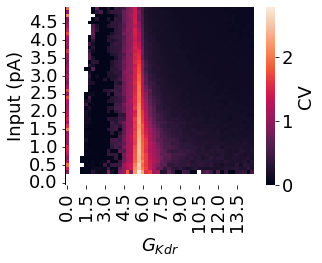

In [17]:
import seaborn as sns
import pandas as pd
# Create a heatmap
df_cv = pd.DataFrame(datacv, index = np.round(range_input,3),
                  columns = np.round(range_gn,2))
plt.figure(figsize=(5,4))  
ax = sns.heatmap(df_cv,cbar_kws={'label': 'CV'})#, vmin=2, vmax=43)
plt.xlabel(r'$G_{Kdr}$')
plt.ylabel('Input (pA)')
ax.invert_yaxis()
ax.axhline(y=0, color='k',linewidth=1)
ax.axvline(x=0, color='k',linewidth=1)
# Show the heatmap
plt.tight_layout()
plt.savefig('CV_gkdr.png')
plt.savefig('CV_gkdr.pdf')
plt.show()

In [52]:
##gnap
trials = 1
gn = [0, 0.15, 0.35]

range_input = np.arange(0,5,0.1) #[1,2,3] #np.arange(1.0,1.5,0.05) #0.025)
range_gn = np.arange(0,0.5,0.01) #[0, 0.15, 0.35]#np.arange(0,1,0.1) #[0, 0.15, 0.35] # #0.01)
dataf = np.zeros((len(range_input),len(range_gn)))
datacv = np.zeros((len(range_input),len(range_gn)))

counti=0
for m in range_input:
  countj=0
  for n in range_gn:
        neuron = HHca(D=0.1,Gnap=n)
        v = np.zeros(len(tf))

        I = np.zeros_like(tf)
        freq = ff
        curr_level=m

        for i in range(len(tf)-1):
            neuron.eval(curr_level,0,0,dt,i*dt)
            v[i] = neuron.v

        peaks, _ = find_peaks(v, height=0)

        dataf[counti,countj]=(len(peaks)/2)
        isi = np.diff(peaks)*dt
        cv = (np.std(isi)/np.mean(isi))
        datacv[counti,countj] = cv

        countj = countj + 1
  counti = counti+1
      

/Users/rodrigo/anaconda3/envs/bri/lib/python3.7/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/Users/rodrigo/anaconda3/envs/bri/lib/python3.7/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/Users/rodrigo/anaconda3/envs/bri/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/rodrigo/anaconda3/envs/bri/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/rodrigo/anaconda3/envs/bri/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


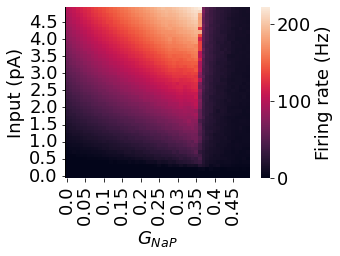

In [74]:
import seaborn as sns
import pandas as pd
# Create a heatmap
df_f = pd.DataFrame(dataf, index = np.round(range_input,3),
                  columns = np.round(range_gn,2))
plt.figure(figsize=(5,4))  
ax = sns.heatmap(df_f,cbar_kws={'label': 'Firing rate (Hz)'})#, vmin=2, vmax=43)
plt.xlabel(r'$G_{NaP}$')
plt.ylabel('Input (pA)')
plt.tight_layout()
ax.invert_yaxis()
ax.axhline(y=0, color='k',linewidth=1)
ax.axvline(x=0, color='k',linewidth=1)
# Show the heatmap

plt.savefig('FR.png')
plt.savefig('FR.pdf')
plt.show()

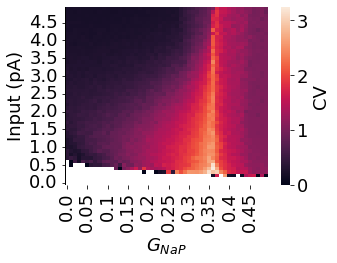

In [72]:
import seaborn as sns
import pandas as pd
# Create a heatmap
df_cv = pd.DataFrame(datacv, index = np.round(range_input,3),
                  columns = np.round(range_gn,2))
plt.figure(figsize=(5,4))  
ax = sns.heatmap(df_cv,cbar_kws={'label': 'CV'})#, vmin=2, vmax=43)
plt.xlabel(r'$G_{NaP}$')
plt.ylabel('Input (pA)')
ax.invert_yaxis()
ax.axhline(y=0, color='k',linewidth=1)
ax.axvline(x=0, color='k',linewidth=1)
# Show the heatmap
plt.tight_layout()
plt.savefig('CV.png')
plt.savefig('CV.pdf')
plt.show()